In [1]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

2025-06-15 10:29:38.744268: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 10:29:38.747775: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 10:29:38.755942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749979778.769606   98989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749979778.773980   98989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749979778.786629   98989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# 📝 STEP 1: Define a word list (or load your own)
with open("presentations/002-rnn-word-suggestions/words.txt") as f:  # Get from https://github.com/dwyl/english-words
    word_list = [line.strip() for line in f if len(line.strip()) > 3]

# Limit dataset for memory (increase later if needed)
word_list = list(set(word_list))[:20000]  # Cap to 20k unique words

In [3]:
# 🧠 STEP 2: Character encoding
chars = sorted(list(set("".join(word_list))))
char_to_idx = {ch: idx + 1 for idx, ch in enumerate(chars)}  # 0 reserved for padding
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}
vocab_size = len(char_to_idx) + 1
len(char_to_idx)

58

In [4]:
def encode_word(word):
    return [char_to_idx[c] for c in word if c in char_to_idx]

In [5]:
# 🎯 STEP 3: Create prefix-input → full-word-label pairs
inputs, targets = [], []
for word in word_list:
    for i in range(1, len(word)):
        prefix = word[:i]
        inputs.append(encode_word(prefix))
        targets.append(word)

In [6]:
# Pad inputs
max_len = max(len(seq) for seq in inputs)
X = pad_sequences(inputs, maxlen=max_len)

In [7]:
# Encode targets as class indices
unique_words = sorted(list(set(targets)))
word_to_idx = {w: i for i, w in enumerate(unique_words)}
idx_to_word = {i: w for w, i in word_to_idx.items()}
y = np.array([word_to_idx[w] for w in targets])

In [ ]:
# 🔀 STEP 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🏗️ STEP 5: Build model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(128),
    Dense(len(unique_words), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# 🏃 STEP 6: Train 🙏
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20


/home/nambanumben/Code/mtech/deep_learning/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-15 10:29:42.562043: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


955/955 ━━━━━━━━━━━━━━━━━━━━ 72s 74ms/step - loss: 9.7907 - sparse_categorical_accuracy: 2.0937e-04 - val_loss: 8.6807 - val_sparse_categorical_accuracy: 0.0030
Epoch 2/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 63s 66ms/step - loss: 7.9746 - sparse_categorical_accuracy: 0.0126 - val_loss: 6.9902 - val_sparse_categorical_accuracy: 0.0332
Epoch 3/20
955/955 ━━━━━━━━━━━━━━━━━━━━ 62s 65ms/step - loss: 6.2686 - sparse_categorical_accuracy: 0.0633 - val_loss: 5.9824 - val_sparse_categorical_accuracy: 0.0796
Epoch 4/20
954/955 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5.2452 - sparse_categorical_accuracy: 0.1301

In [ ]:
# 🔎 STEP 7: Predict completions
def suggest_words(prefix, top_k=5):
    encoded = encode_word(prefix)
    padded = pad_sequences([encoded], maxlen=max_len)
    preds = model.predict(padded)[0]
    top_indices = preds.argsort()[-top_k:][::-1]
    return [idx_to_word[i] for i in top_indices]

In [ ]:
# ✅ Example usage
print("Suggestions for 'Hel':", suggest_words("Hel"))
print("Suggestions for 'Sta':", suggest_words("Sta"))
print("Suggestions for 'Pla':", suggest_words("Pla"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Suggestions for 'Hel': ['Helles', 'Helmuth', 'Helvellales', 'Hellenized', 'Hellenising']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Suggestions for 'Sta': ['Stakhanovism', 'Staphylea', 'Stasny', 'Stillman', 'Sthelena']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Suggestions for 'Pla': ['Platonised', 'Platoniser', 'Player', 'Platteville', 'Plion']


265/265 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step

🧪 Test Accuracy: 0.3781


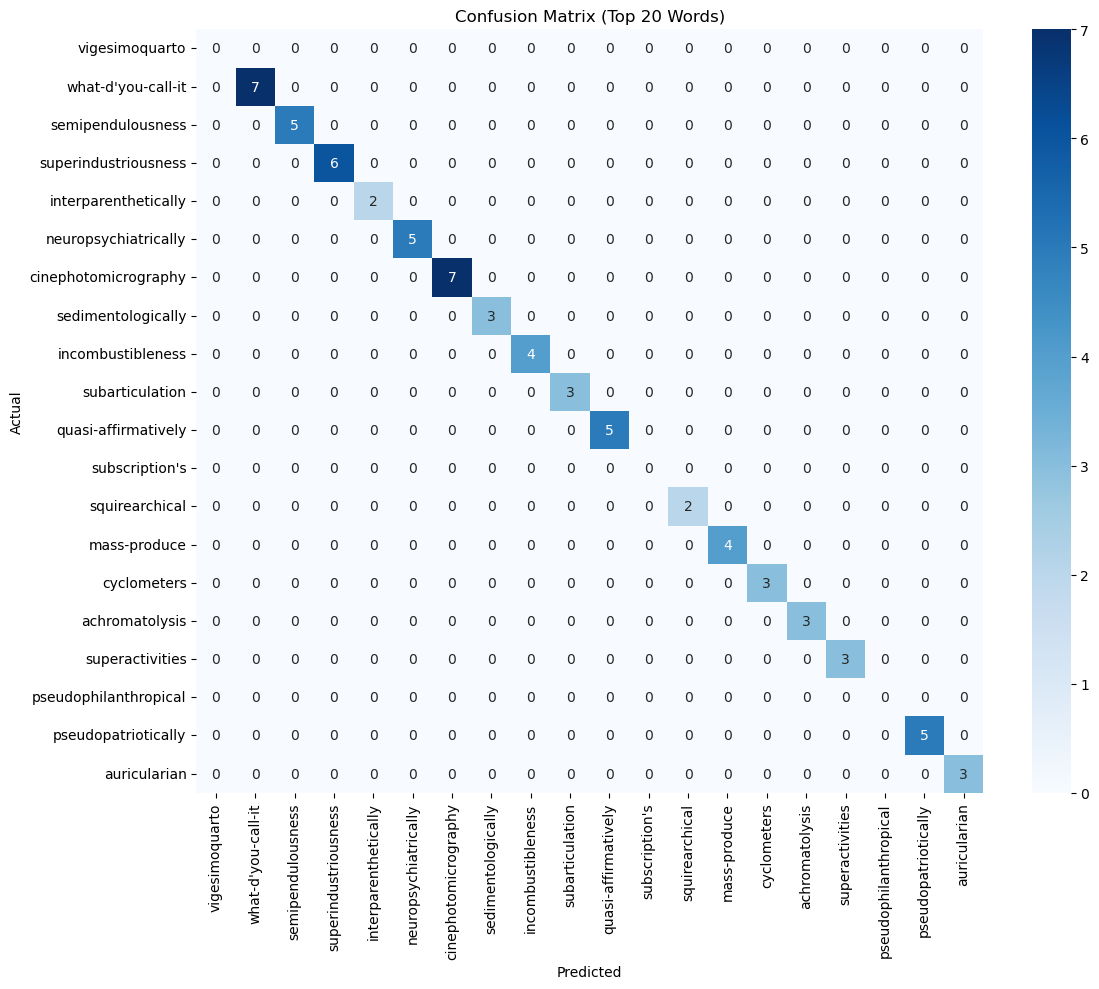

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ✅ STEP 8: Evaluate on test set
y_pred_probs = model.predict(X_test, batch_size=128)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"\n🧪 Test Accuracy: {test_acc:.4f}")

# ✅ Classification report
# print("\n📋 Classification Report:")
# print(classification_report(y_test, y_pred, target_names=[idx_to_word[i] for i in np.unique(y_test)]))

# ✅ Confusion Matrix (only on top N classes to keep it readable)
TOP_N = 20
top_classes = np.bincount(y_test).argsort()[::-1][:TOP_N]

cm = confusion_matrix(y_test, y_pred, labels=top_classes)
labels = [idx_to_word[i] for i in top_classes]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Top 20 Words)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
